<a href="https://colab.research.google.com/github/Nageswar-Sahoo/Computer-Vision-Learning/blob/main/assignment-3/assignment-part-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [48]:
train_transforms = transforms.Compose(
                    [
                  #  transforms.ToPILImage(),
                  #  transforms.RandomRotation(30),
                    transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                  #  transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                  #  transforms.ColorJitter(brightness=0.2, contrast=0.2),
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,)),
                    ])
# don't (really) need the data augmentation in validation
val_transforms = transforms.Compose(
                    [
                   # transforms.ToPILImage(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,)),
                    ])
test_transforms = val_transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [49]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [50]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

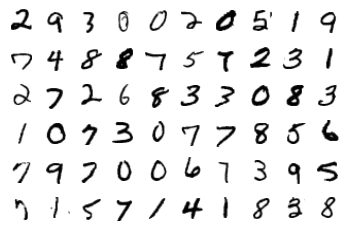

In [51]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [52]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=25, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(25),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=25, out_channels=20, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 5
         # output_size = 5
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        self.dropout = nn.Dropout(0.10)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
    
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [53]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 15, 26, 26]             135
       BatchNorm2d-2           [-1, 15, 26, 26]              30
              ReLU-3           [-1, 15, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]           1,350
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 25, 22, 22]           2,250
       BatchNorm2d-8           [-1, 25, 22, 22]              50
              ReLU-9           [-1, 25, 22, 22]               0
          Dropout-10           [-1, 25, 22, 22]               0
        MaxPool2d-11           [-1, 25, 11, 11]               0
           Conv2d-12           [-1, 20, 11, 11]             500

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [54]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [55]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.6)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.0777868703007698 Batch_id=468 Accuracy=95.29: 100%|██████████| 469/469 [00:17<00:00, 26.15it/s]



Test set: Average loss: 0.0522, Accuracy: 9868/10000 (98.68%)

EPOCH: 1


Loss=0.07453445345163345 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:18<00:00, 25.51it/s]



Test set: Average loss: 0.0583, Accuracy: 9829/10000 (98.29%)

EPOCH: 2


Loss=0.022146673873066902 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:18<00:00, 25.84it/s]



Test set: Average loss: 0.0291, Accuracy: 9915/10000 (99.15%)

EPOCH: 3


Loss=0.05193787440657616 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:18<00:00, 24.75it/s]



Test set: Average loss: 0.0300, Accuracy: 9920/10000 (99.20%)

EPOCH: 4


Loss=0.040393345057964325 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:18<00:00, 26.03it/s]



Test set: Average loss: 0.0275, Accuracy: 9915/10000 (99.15%)

EPOCH: 5


Loss=0.02475900761783123 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:18<00:00, 25.75it/s]



Test set: Average loss: 0.0227, Accuracy: 9935/10000 (99.35%)

EPOCH: 6


Loss=0.035011906176805496 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:18<00:00, 25.89it/s]



Test set: Average loss: 0.0235, Accuracy: 9933/10000 (99.33%)

EPOCH: 7


Loss=0.010059074498713017 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:18<00:00, 25.84it/s]



Test set: Average loss: 0.0230, Accuracy: 9936/10000 (99.36%)

EPOCH: 8


Loss=0.029662450775504112 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:18<00:00, 25.92it/s]



Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.009749043732881546 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:17<00:00, 26.30it/s]



Test set: Average loss: 0.0216, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.023435136303305626 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:17<00:00, 26.54it/s]



Test set: Average loss: 0.0207, Accuracy: 9941/10000 (99.41%)

EPOCH: 11


Loss=0.04859842732548714 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:17<00:00, 26.48it/s]



Test set: Average loss: 0.0215, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.012518470175564289 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:17<00:00, 26.10it/s]



Test set: Average loss: 0.0223, Accuracy: 9932/10000 (99.32%)

EPOCH: 13


Loss=0.012371142394840717 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:19<00:00, 24.57it/s]



Test set: Average loss: 0.0210, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Loss=0.034355949610471725 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:17<00:00, 26.39it/s]



Test set: Average loss: 0.0209, Accuracy: 9941/10000 (99.41%)



In [56]:

train_losses_numpy=[]
for a in train_losses:
  train_losses_numpy.append(a.cpu().item())

Text(0.5, 1.0, 'Test Accuracy')

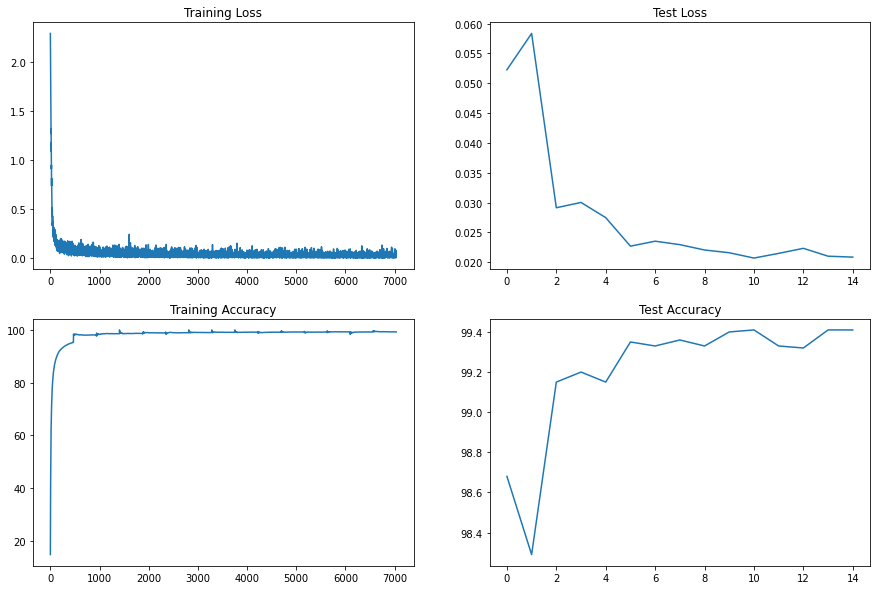

In [57]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_numpy)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")